Imports

In [17]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms import functional as F
import torchvision.models as models
from PIL import Image
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

In [18]:
data_folder = 'data'
annotations_file = 'data/groundtruth.txt'

Preparing the Dataset

In [19]:
class VehicleTrackingDataset(Dataset):
    def __init__(self, data_folder, annotations_file, output_size=(227, 227), context_factor=2):
        self.data_folder = data_folder
        self.output_size = output_size
        self.context_factor = context_factor
        self.annotations = np.loadtxt(annotations_file, delimiter=',')
        self.image_files = [os.path.join(data_folder, f'{index + 1:08}.jpg') for index in range(len(self.annotations))]
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.image_files) - 1

    def __getitem__(self, index):
        # load the current and next images using the index.
        image_current = cv2.imread(self.image_files[index])
        image_next = cv2.imread(self.image_files[index + 1])
        image_current = cv2.cvtColor(image_current, cv2.COLOR_BGR2RGB)
        image_next = cv2.cvtColor(image_next, cv2.COLOR_BGR2RGB)

        #normalize images
        image_current = image_current.astype(np.float32) / 255.0
        image_next = image_next.astype(np.float32) / 255.0

        # extract bounding box coordinates from the annotations.
        bbox = self.annotations[index]
        xmin, ymin, xmax, ymax = min(bbox[0::2]), min(bbox[1::2]), max(bbox[0::2]), max(bbox[1::2])

        # proceed with cropping and resizing logic.
        target_crop = self.crop_and_resize(image_current, (xmin, ymin, xmax, ymax), 1, self.output_size)
        search_region_crop, (xmin_context, ymin_context, xmax_context, ymax_context) = self.crop_and_resize(image_next, (xmin, ymin, xmax, ymax), self.context_factor, self.output_size, return_context=True)

        #scale factors based on the cropped (before resize) and target dimensions.
        original_width = xmax_context - xmin_context
        original_height = ymax_context - ymin_context
        target_width, target_height = self.output_size
        scale_w = target_width / original_width
        scale_h = target_height / original_height

        # adjust ground truth bbox relative to the search region and apply scale.
        gt_bbox_relative_scaled = (
            (xmin - xmin_context) * scale_w,
            (ymin - ymin_context) * scale_h,
            (xmax - xmin_context) * scale_w,
            (ymax - ymin_context) * scale_h
        )

        gt_bbox_relative_scaled = (
            gt_bbox_relative_scaled[0] / self.output_size[0],  # Normalize x_min
            gt_bbox_relative_scaled[1] / self.output_size[1],  # Normalize y_min
            gt_bbox_relative_scaled[2] / self.output_size[0],  # Normalize x_max
            gt_bbox_relative_scaled[3] / self.output_size[1]   # Normalize y_max
        )

        # Convert to tensor.

        target_crop = F.to_tensor(target_crop)
        search_region_crop = F.to_tensor(search_region_crop)
        target_crop = self.normalize(target_crop)
        search_region_crop = self.normalize(search_region_crop)
        gt_bbox_relative_scaled = torch.tensor(gt_bbox_relative_scaled, dtype=torch.float32)

        return target_crop, search_region_crop, gt_bbox_relative_scaled


    def crop_and_resize(self, image, bbox, context_factor, output_size, return_context=False):
        xmin, ymin, xmax, ymax = bbox
        width = xmax - xmin
        height = ymax - ymin

        # adjust the bounding box to add context
        context_width = width * (context_factor - 1)
        context_height = height * (context_factor - 1)
        xmin_context = max(int(xmin - context_width / 2), 0)
        ymin_context = max(int(ymin - context_height / 2), 0)
        xmax_context = min(int(xmax + context_width / 2), image.shape[1])
        ymax_context = min(int(ymax + context_height / 2), image.shape[0])

        # crop and resize
        cropped_image = image[ymin_context:ymax_context, xmin_context:xmax_context]
        resized_image = cv2.resize(cropped_image, output_size, interpolation=cv2.INTER_LINEAR)

        if return_context:
            return resized_image, (xmin_context, ymin_context, xmax_context, ymax_context)
        return resized_image

Visualize the data after transformations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


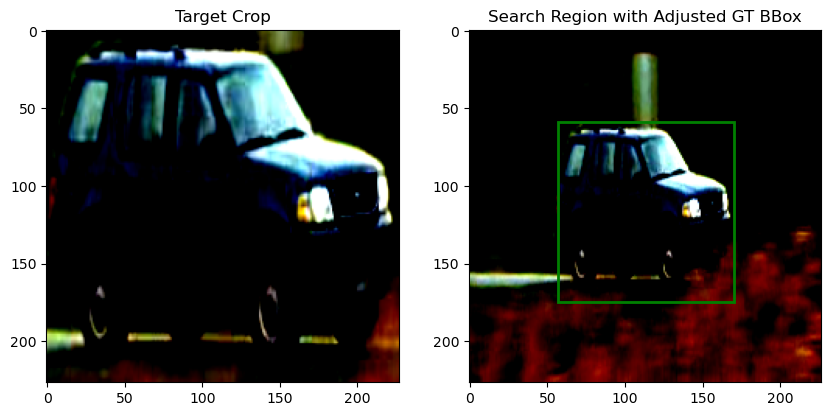

'\nmultiply model ouytputs by 227\nnow you have coordinates with respect to the search region (t+1) frame\nsearch region is cropped with respect to the previous bounding box and added padding\n\n'

In [20]:
def plot_crops_with_bbox(target_crop, search_region_crop, gt_bbox_relative):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(target_crop)
    axs[0].set_title("Target Crop")
    axs[1].imshow(search_region_crop)
    # draw the adjusted bbox on the search region crop
    gt_bbox_relative *= 227
    rect = patches.Rectangle((gt_bbox_relative[0], gt_bbox_relative[1]), gt_bbox_relative[2] - gt_bbox_relative[0], gt_bbox_relative[3] - gt_bbox_relative[1], linewidth=2, edgecolor='g', facecolor='none')
    axs[1].add_patch(rect)
    axs[1].set_title("Search Region with Adjusted GT BBox")
    plt.show()



dataset = VehicleTrackingDataset(data_folder, annotations_file)
# visualize for an example pair from the dataset
target_crop, search_region_crop, gt_bbox_relative = dataset[200]
target_crop = target_crop.permute(1, 2, 0).numpy()
search_region_crop = search_region_crop.permute(1, 2, 0).numpy()
gt_bbox_relative = gt_bbox_relative.numpy()
plot_crops_with_bbox(target_crop, search_region_crop, gt_bbox_relative)


"""
multiply model ouytputs by 227
now you have coordinates with respect to the search region (t+1) frame
search region is cropped with respect to the previous bounding box and added padding

"""

Defining the Model Architecture
GoTurn

In [21]:
class ObjectTrackerModel(nn.Module):
    def __init__(self):
        super(ObjectTrackerModel, self).__init__()
        # loading a pre-trained AlexNet
        alexnet = models.alexnet(pretrained=True)

        # using the features portion of AlexNet up to the classifier
        self.shared_conv_layers = alexnet.features

        # freezing these layers
        for param in self.shared_conv_layers.parameters():
            param.requires_grad = False


        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 6 * 6 * 2, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4),
            nn.Sigmoid()  
        )

    def forward(self, prev_crop, curr_search_region):
        # processing both inputs through the shared convolutional layers
        prev_features = self.shared_conv_layers(prev_crop)
        curr_features = self.shared_conv_layers(curr_search_region)

        # flatten and concatenate features
        prev_features_flat = prev_features.view(prev_features.size(0), -1)
        curr_features_flat = curr_features.view(curr_features.size(0), -1)
        combined_features = torch.cat((prev_features_flat, curr_features_flat), dim=1)

        # pass the combined features through the fully connected layers
        output = self.fc_layers(combined_features)

        return output


Train Test Splits

In [22]:
# split the dataset into training and testing sets
indices = list(range(len(dataset)))  # assuming 'dataset' is your instance of VehicleTrackingDataset
train_indices, test_indices = train_test_split(indices, test_size=0.2, shuffle = False)

# training and testing subsets
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# dataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

Training Loop and DataLoader

Epoch 1/20 | Train Loss: 0.0707 | Test Loss: 0.0577
Epoch 2/20 | Train Loss: 0.0620 | Test Loss: 0.0854
Epoch 3/20 | Train Loss: 0.0578 | Test Loss: 0.0609
Epoch 4/20 | Train Loss: 0.0482 | Test Loss: 0.0267
Epoch 5/20 | Train Loss: 0.0599 | Test Loss: 0.0525
Epoch 6/20 | Train Loss: 0.0499 | Test Loss: 0.0464
Epoch 7/20 | Train Loss: 0.0415 | Test Loss: 0.0353
Epoch 8/20 | Train Loss: 0.0363 | Test Loss: 0.0430
Epoch 9/20 | Train Loss: 0.0350 | Test Loss: 0.0396
Epoch 10/20 | Train Loss: 0.0322 | Test Loss: 0.0364
Epoch 11/20 | Train Loss: 0.0313 | Test Loss: 0.0370
Epoch 12/20 | Train Loss: 0.0320 | Test Loss: 0.0370
Epoch 13/20 | Train Loss: 0.0319 | Test Loss: 0.0372
Epoch 14/20 | Train Loss: 0.0294 | Test Loss: 0.0376
Epoch 15/20 | Train Loss: 0.0322 | Test Loss: 0.0381
Epoch 16/20 | Train Loss: 0.0289 | Test Loss: 0.0381
Epoch 17/20 | Train Loss: 0.0318 | Test Loss: 0.0381
Epoch 18/20 | Train Loss: 0.0301 | Test Loss: 0.0381
Epoch 19/20 | Train Loss: 0.0317 | Test Loss: 0.0379
Ep

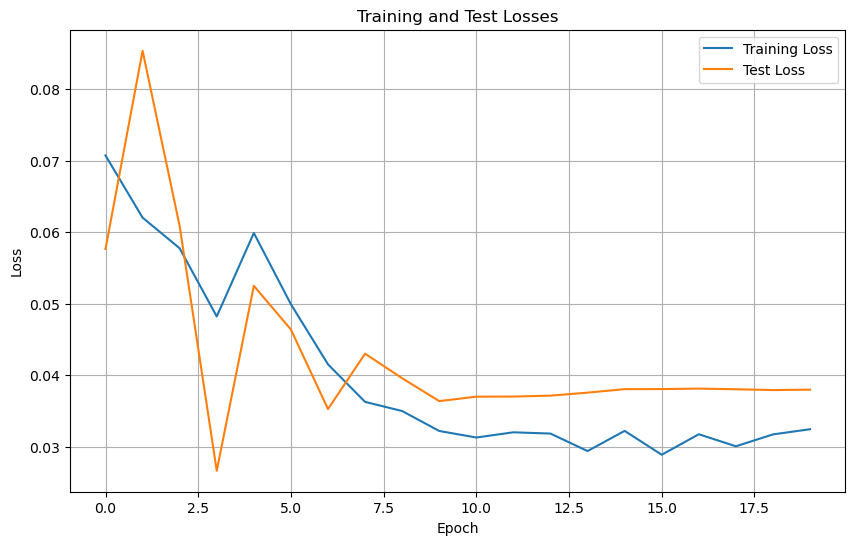

In [26]:
# load the model
model = ObjectTrackerModel()

if torch.cuda.is_available():
    model = model.cuda()

# defining L1 Loss with adam optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

# defining the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 20

# lists to store loss values
train_losses = []
test_losses = []

# training loop
for epoch in range(num_epochs):
    # training Phase
    model.train()
    train_loss = 0.0
    for target_crop, search_region_crop, gt_bbox_relative in train_loader:

        if torch.cuda.is_available():
            target_crop, search_region_crop, gt_bbox_relative = target_crop.cuda(), search_region_crop.cuda(), gt_bbox_relative.cuda()

        optimizer.zero_grad()  # zero the parameter gradients
        outputs = model(target_crop, search_region_crop)  # forward pass
        loss = criterion(outputs, gt_bbox_relative)  # compute loss
        loss.backward()  # backward pass
        optimizer.step()  # pptimize

        train_loss += loss.item() * target_crop.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # step the scheduler
    scheduler.step()

    # testing Phase
    model.eval()
    test_loss = 0.0
    with torch.no_grad():  # no gradients needed for testing
        for target_crop, search_region_crop, gt_bbox_relative in test_loader:
           
            if torch.cuda.is_available():
                target_crop, search_region_crop, gt_bbox_relative = target_crop.cuda(), search_region_crop.cuda(), gt_bbox_relative.cuda()

            outputs = model(target_crop, search_region_crop)  # forward pass
            loss = criterion(outputs, gt_bbox_relative)  # compute loss

            test_loss += loss.item() * target_crop.size(0)
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}')

# plotting the training and test losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
model_path = 'weights/model.pth'

# save the model state dictionary
torch.save(model.state_dict(), model_path)


Model Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Outputs:  [0.25884137 0.28075394 0.7452627  0.74424756]
Ground Truths: [0.25118482 0.25824177 0.7511848  0.7692308 ]


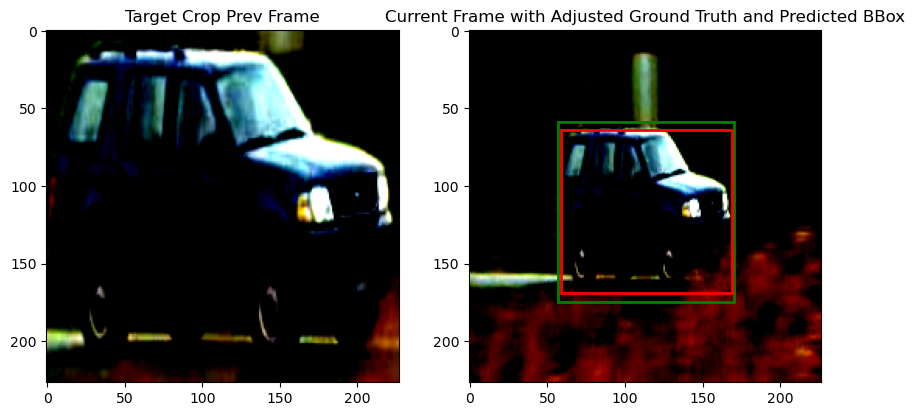

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Outputs:  [0.2963747  0.30362952 0.7018524  0.7078869 ]
Ground Truths: [0.2004717 0.2617801 0.7334906 0.7801047]


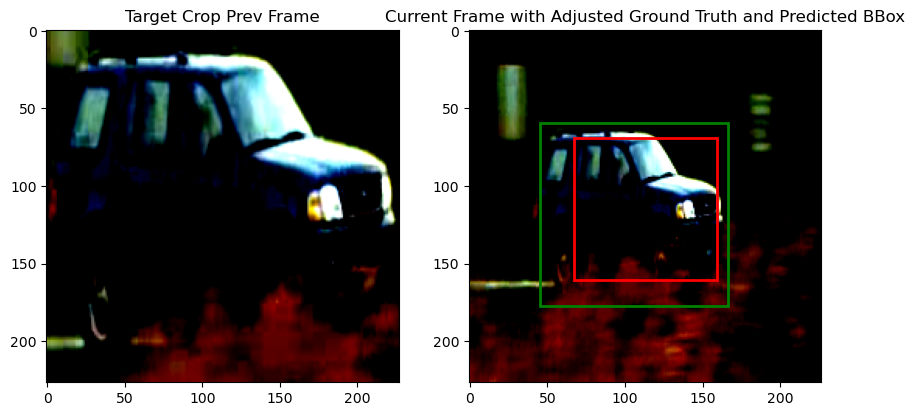

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Outputs:  [0.277306   0.28806362 0.7115102  0.7188608 ]
Ground Truths: [0.14285715 0.25263157 0.71428573 0.7526316 ]


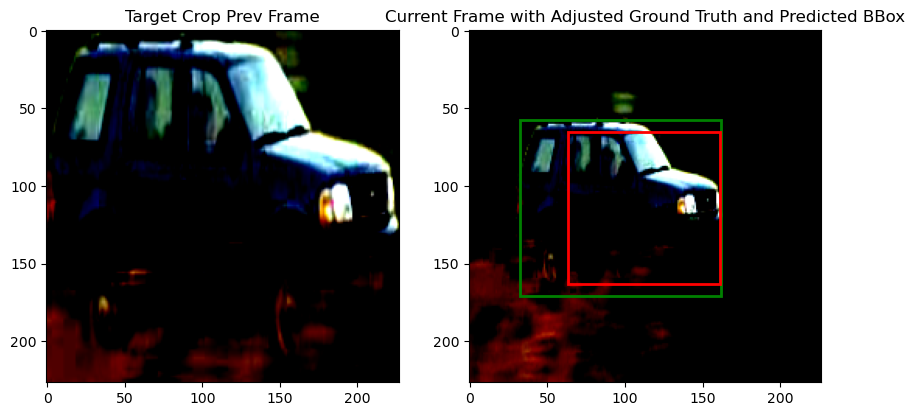

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Outputs:  [0.2891763 0.2992222 0.7011259 0.7023456]
Ground Truths: [0.13901345 0.25       0.71300447 0.75      ]


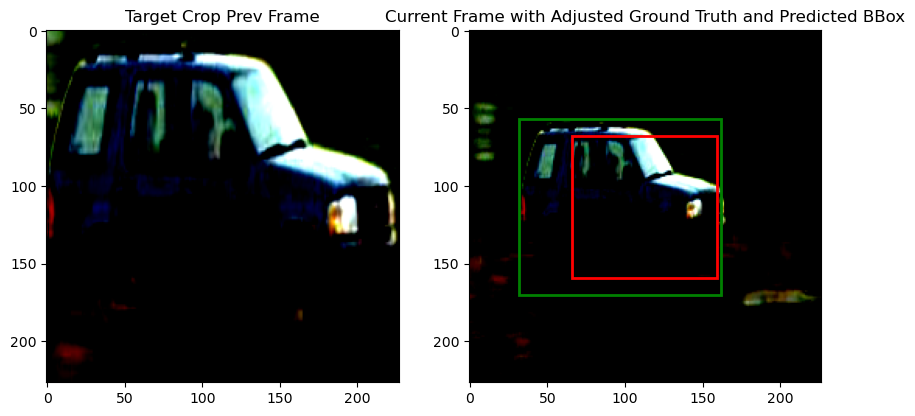

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Outputs:  [0.27832893 0.2821814  0.7056112  0.7191192 ]
Ground Truths: [0.14081633 0.2777778  0.71428573 0.8287037 ]


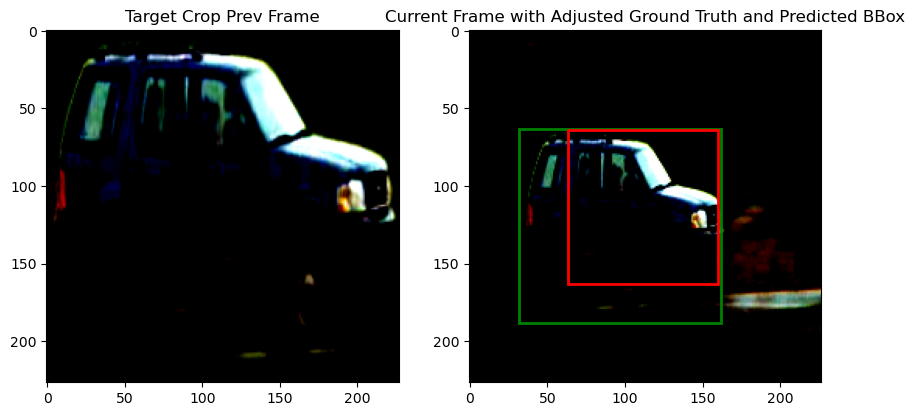

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Outputs:  [0.25618762 0.27382454 0.7386094  0.7396189 ]
Ground Truths: [0.1744186  0.25943395 0.7248062  0.7783019 ]


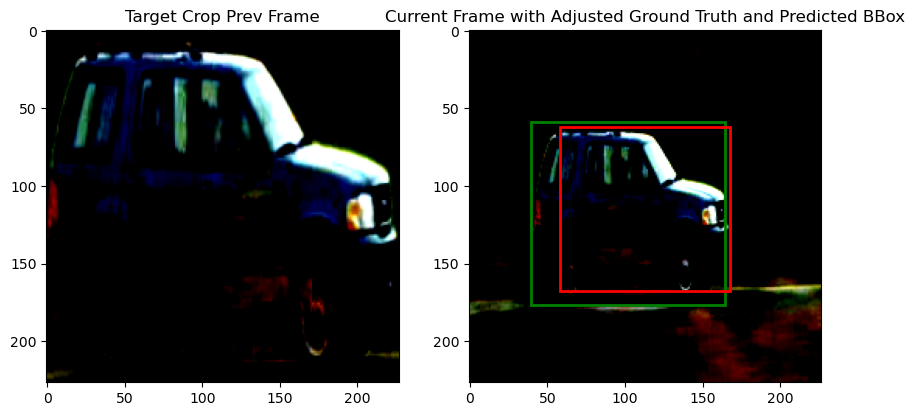

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Outputs:  [0.25753617 0.2729183  0.74817187 0.74207675]
Ground Truths: [0.19082569 0.26605505 0.7302752  0.79357797]


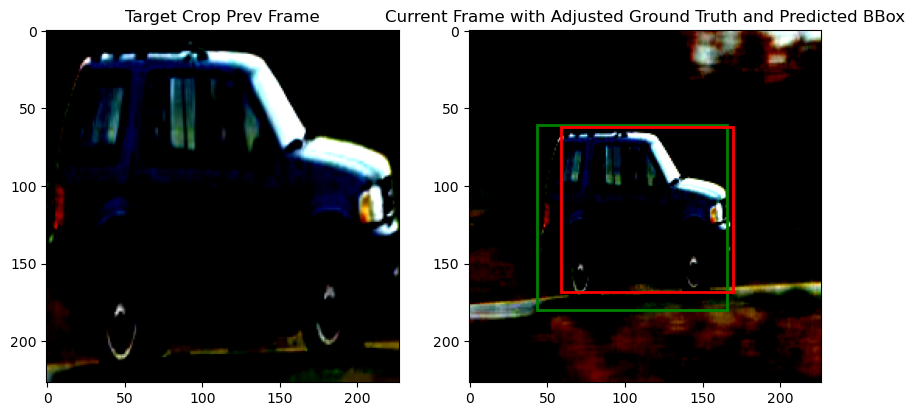

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Outputs:  [0.25140643 0.2718776  0.7511535  0.7452565 ]
Ground Truths: [0.20877193 0.25688073 0.7368421  0.76605505]


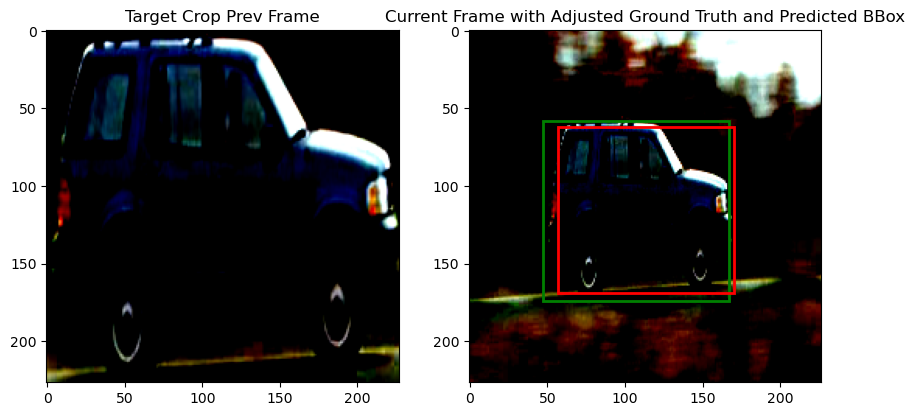

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Outputs:  [0.25870696 0.2759508  0.7501602  0.7447369 ]
Ground Truths: [0.24310344 0.25438598 0.7482759  0.75877196]


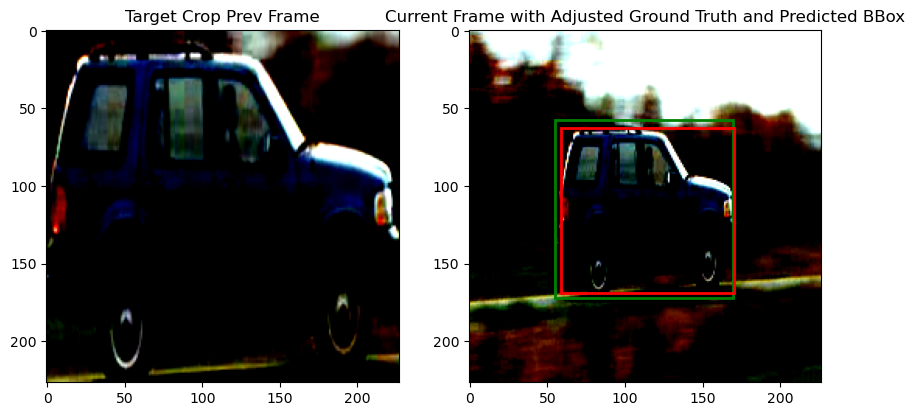

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Outputs:  [0.2615848  0.27480578 0.74978966 0.74011433]
Ground Truths: [0.25083056 0.25438598 0.7508306  0.75877196]


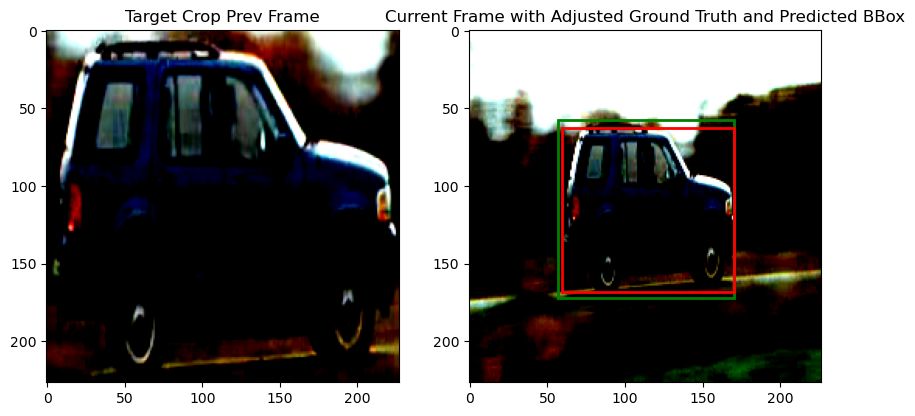

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Outputs:  [0.27282473 0.27821016 0.74062765 0.72762513]
Ground Truths: [0.25 0.25 0.75 0.75]


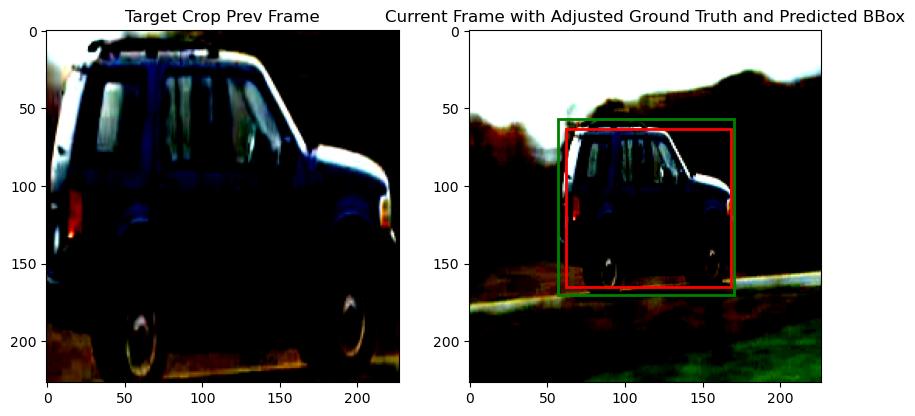

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Outputs:  [0.28073412 0.2914107  0.7222665  0.71683216]
Ground Truths: [0.2508834 0.25      0.7508834 0.75     ]


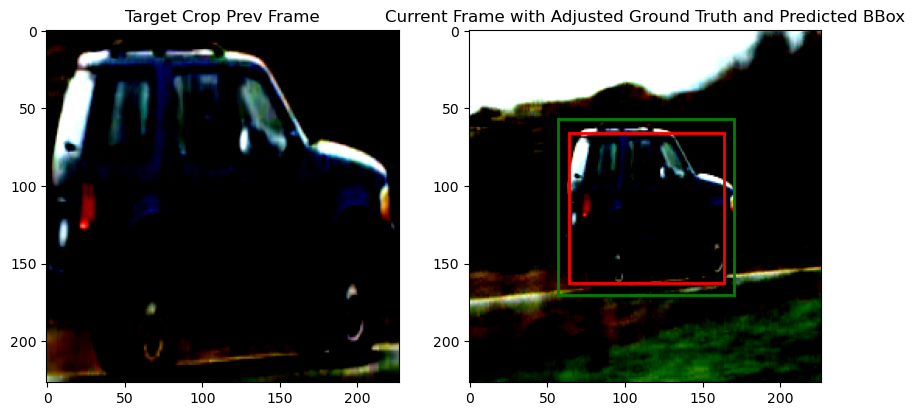

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Outputs:  [0.29108754 0.30479473 0.69797397 0.6943797 ]
Ground Truths: [0.26959848 0.25       0.8087954  0.75      ]


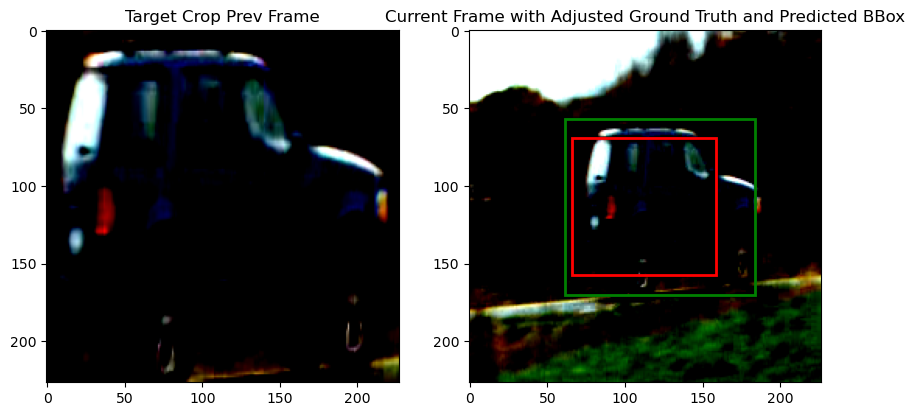

In [28]:
def plot_crops_with_bbox_preds(target_crop, search_region_crop, gt_bbox_relative,outputs):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(target_crop)
    axs[0].set_title("Target Crop Prev Frame")
    axs[1].imshow(search_region_crop)
    # draw the adjusted bbox on the search region crop
    gt_bbox_relative *= 227
    outputs *= 227
    rect = patches.Rectangle((gt_bbox_relative[0], gt_bbox_relative[1]), gt_bbox_relative[2] - gt_bbox_relative[0], gt_bbox_relative[3] - gt_bbox_relative[1], linewidth=2, edgecolor='g', facecolor='none')
    rect2 = patches.Rectangle((outputs[0], outputs[1]), outputs[2] - outputs[0], outputs[3] - outputs[1], linewidth=2, edgecolor='r', facecolor='none')
    axs[1].add_patch(rect)
    axs[1].add_patch(rect2)
    axs[1].set_title("Current Frame with Adjusted Ground Truth and Predicted BBox")
    plt.show()

# set model to evaluation mode
model.eval()

# iterate through the test dataset
for i, (target_crop, search_region_crop, gt_bbox_relative) in enumerate(test_loader):
    if torch.cuda.is_available():
        target_crop, search_region_crop = target_crop.cuda(), search_region_crop.cuda()

    # forward pass through the model
    with torch.no_grad():
        outputs = model(target_crop, search_region_crop)


    # take the first item in the batch
    target_crop = target_crop[0]
    search_region_crop = search_region_crop[0]
    gt_bbox_relative = gt_bbox_relative[0].cpu().numpy()
    outputs = outputs[0].cpu().numpy()
    print("Outputs: ",outputs )
    print("Ground Truths:", gt_bbox_relative)


    # convert predictions and ground truth to numpy arrays
    target_crop = target_crop.permute(1, 2, 0).cpu().numpy()
    search_region_crop = search_region_crop.permute(1, 2, 0).cpu().numpy()


    # visualize the results
    plot_crops_with_bbox_preds(target_crop, search_region_crop, gt_bbox_relative, outputs)

    # limit visualization to a few examples
    if i == 20:
        break
